In [1]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm
import time

from utils import set_plotting_style, get_chunking, get_chunking_dask, make_df, hist2d_dask, query_dis
import utils

from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
from dask import delayed
from yahist import Hist1D, Hist2D

In [2]:
set_plotting_style()

In [43]:
client = Client("tcp://169.228.130.74:17252")
client

Client Scheduler: tcp://169.228.130.74:17252 Dashboard: http://169.228.130.74:13345/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [44]:
# fnames = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v11_unblind1fb_RAW_v11//*.root")
fnames = glob.glob("/hadoop/cms/store/user/namin/ScoutingCaloMuon/*_unblind/*/*/*.root")
# fnames = fnames[:5]

branches = ["dimuon_mass", "pass_*","logabsetaphi","DV_rhoCorr","DV_x","DV_y", "minabsdxy", "Muon_*PixelHits", "DV_inPixel*"]
# cut = "pass_baseline_iso"
# cut = "pass_skim"
cut = "pass_baseline"

ddf = make_df(
    fnames,
    branches = branches,
    cut = cut,
    chunksize = 1e6,
    persist = True,
    use_dask = True,
    npartitions = len(fnames)//3,
)

KeyError: not found: b'dimuon_mass'
 in file: /hadoop/cms/store/user/namin/ScoutingCaloMuon/crab_skim_2017C_v11_unblind/200127_230845/0000/output_1.root

In [42]:
# from dask.distributed import progress
# print(progress(ddf))
dir(ddf)

['DV_rhoCorr',
 'DV_x',
 'DV_y',
 'Muon1_nExpectedPixelHits',
 'Muon1_nValidPixelHits',
 'Muon2_nExpectedPixelHits',
 'Muon2_nValidPixelHits',
 '_HTML_FMT',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_ufunc__',
 '__array_wrap__',
 '__await__',
 '__bool__',
 '__class__',
 '__complex__',
 '__dask_graph__',
 '__dask_keys__',
 '__dask_layers__',
 '__dask_optimize__',
 '__dask_postcompute__',
 '__dask_postpersist__',
 '__dask_scheduler__',
 '__dask_tokenize__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__iter__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__reduce__',
 '__reduce_ex__'

In [19]:
# client.restart()

In [20]:
# ddf
ddf.memory_usage().sum().compute()*1e-6

54.280952

1233658
CPU times: user 543 ms, sys: 39 ms, total: 582 ms
Wall time: 1.1 s


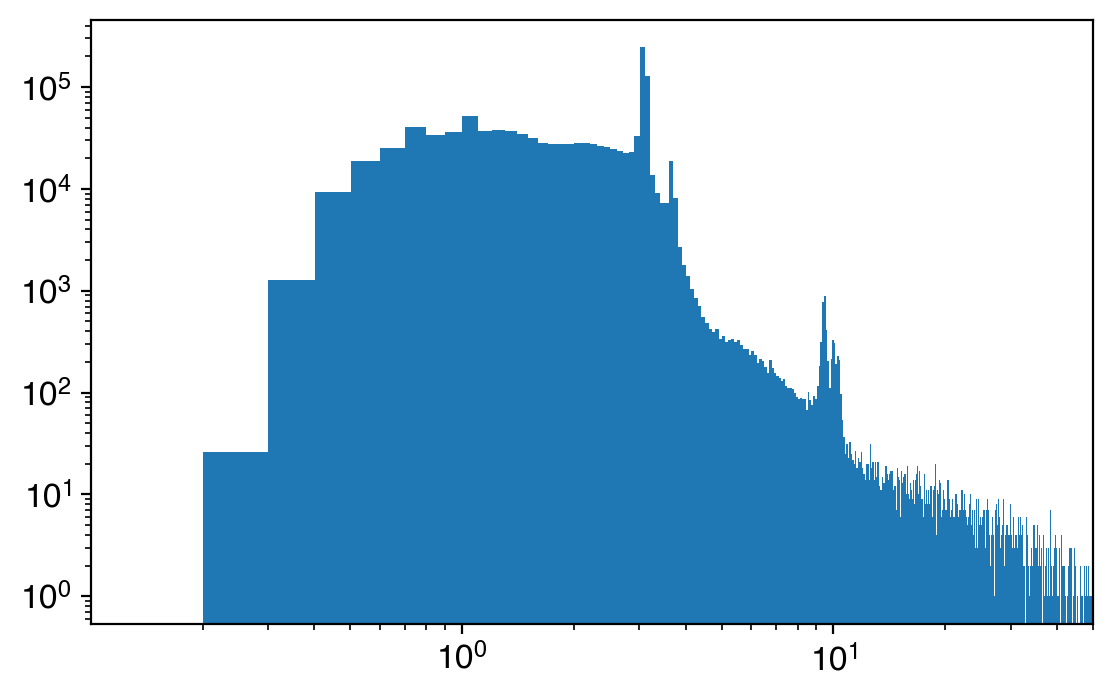

In [21]:
%%time
bins = np.linspace(0,50,500)
counts = da.histogram(da.clip(ddf["dimuon_mass"],bins[0],bins[-1]), bins=bins)[0].compute()
print(counts.sum())
h = Hist1D.from_bincounts(counts, bins, errors=counts**0.5)
h.plot()
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")

1222316
CPU times: user 602 ms, sys: 24 ms, total: 626 ms
Wall time: 926 ms


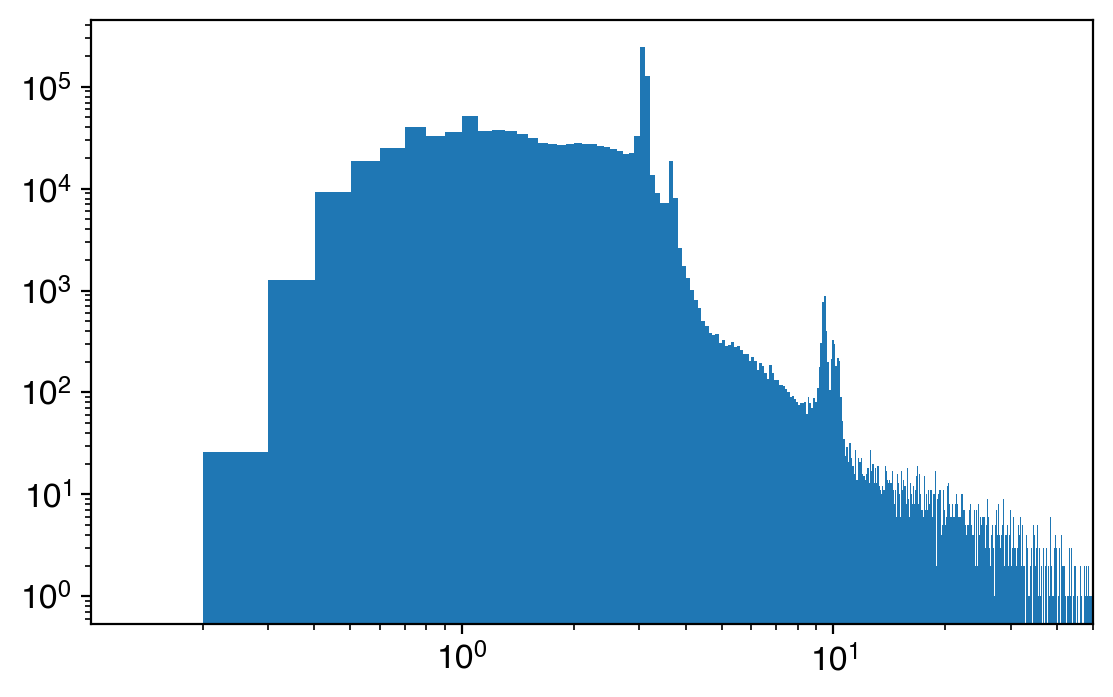

In [22]:
%%time
bins = np.linspace(0,50,500)
counts = da.histogram(da.clip(ddf.query("logabsetaphi<2")["dimuon_mass"],bins[0],bins[-1]), bins=bins)[0].compute()
print(counts.sum())
h = Hist1D.from_bincounts(counts, bins)
h.plot()
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")

In [23]:
%%time
bins = np.linspace(0,50,200)
counts = client.compute(dict(
    num=da.histogram(ddf.query("DV_rhoCorr>1.0 and logabsetaphi>2")["dimuon_mass"], bins=bins)[0],
    den=da.histogram(ddf.query("DV_rhoCorr>1.0 and logabsetaphi>-200")["dimuon_mass"], bins=bins)[0],
),sync=True)

CPU times: user 62 ms, sys: 4 ms, total: 66 ms
Wall time: 340 ms


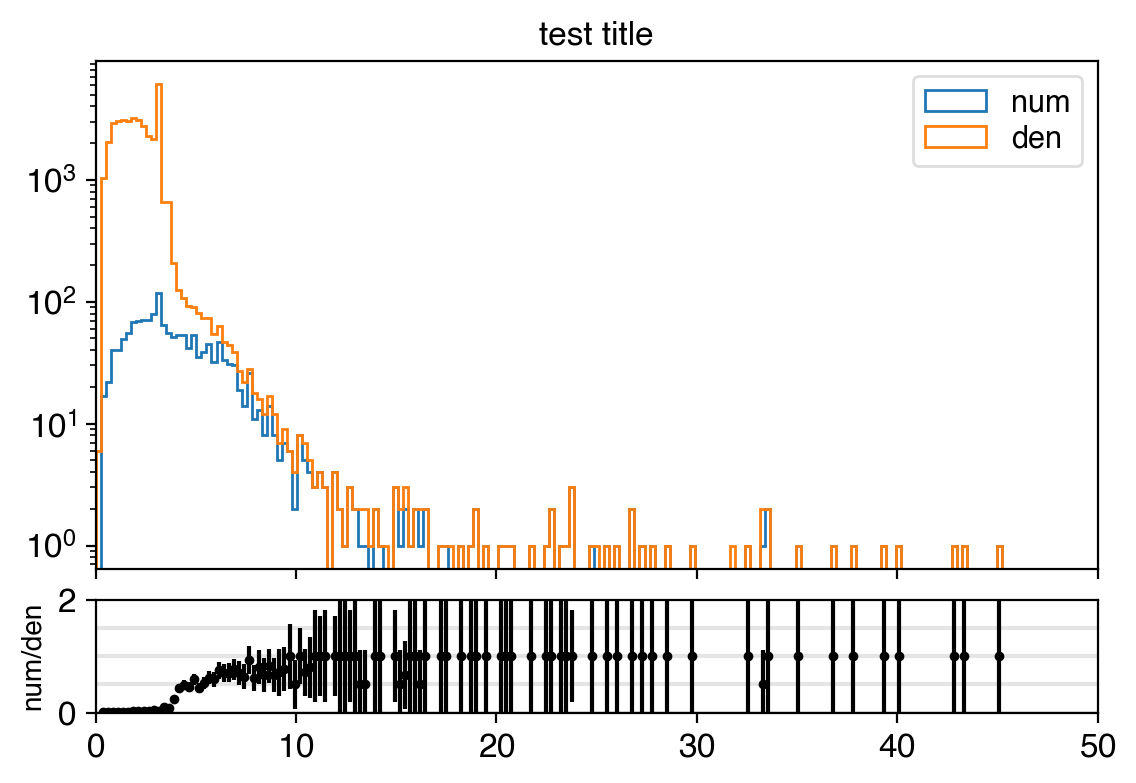

In [24]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,gridspec_kw={'height_ratios':[9, 2],"top":0.94})

hnum = Hist1D.from_bincounts(counts["num"], bins)
hden = Hist1D.from_bincounts(counts["den"], bins)
normalize = False
if normalize:
    hnum = hnum.normalize()
    hden = hden.normalize()
hnum.plot(ax=ax1, histtype="step", label="num")
hden.plot(ax=ax1, histtype="step", label="den")
# ax.set_yscale("log")
# ax.set_xscale("log")

(hnum/hden).plot(ax=ax2,show_errors=True,ms=2.5,color="k")
ax1.set_yscale("log")
ax1.legend()
ax1.set_title("test title")
ax2.set_ylim([0,2.0])
ax2.set_ylabel("num/den",fontsize=10)
# ax2.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax2.hlines(np.arange(0.0,2,0.5),xmin=ax1.get_xlim()[0],xmax=ax1.get_xlim()[1],alpha=0.1)

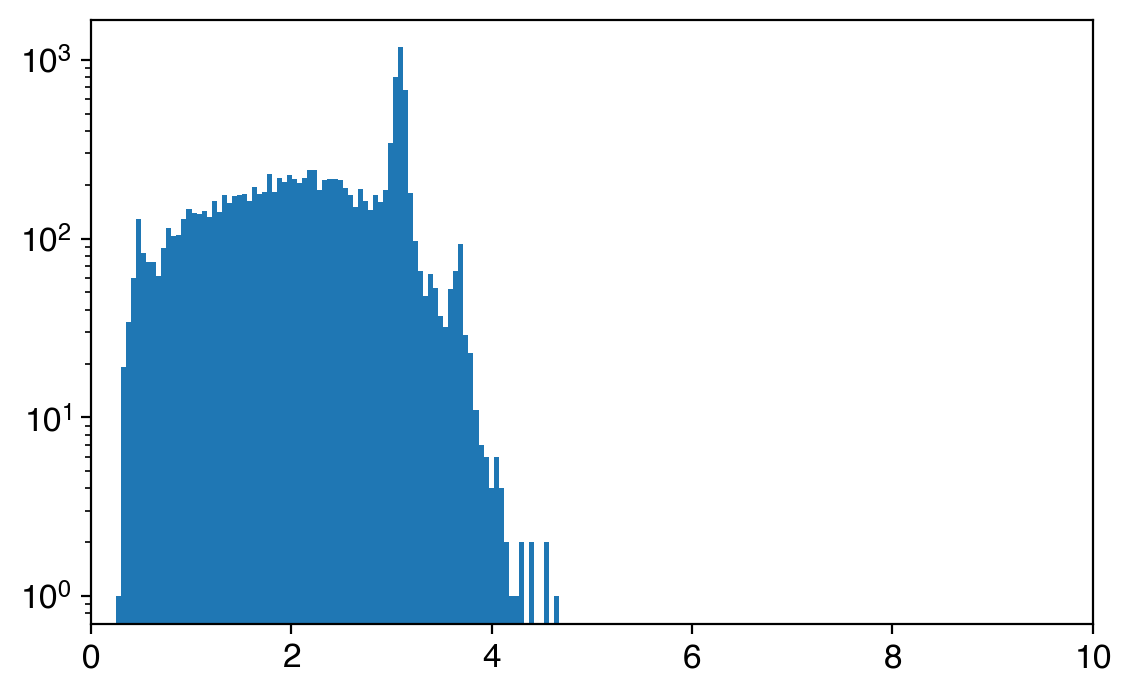

In [31]:
bins = np.linspace(0,10,200)
counts = client.compute(dict(
    num=da.histogram(ddf.query(
        "DV_rhoCorr>1.0 and pass_excesshits and logabsetaphi<1.5 and pass_baseline_iso and minabsdxy > 0.05"
    )["dimuon_mass"], bins=bins)[0],
),sync=True)
h = Hist1D.from_bincounts(counts["num"], bins)
h.plot(log=True)

In [27]:
# ddf.query("DV_rhoCorr>1.0 and dimuon_mass>5 and logabsetaphi<1.5 and pass_baseline_iso and minabsdxy > 0.05").compute()

,dimuon_mass,pass_skim,pass_l1,pass_json,pass_fiducialgen,pass_excesshits,pass_fiducialgen_norho,pass_baseline,pass_baseline_iso,logabsetaphi,DV_rhoCorr,DV_x,DV_y,minabsdxy,Muon1_nValidPixelHits,Muon2_nValidPixelHits,Muon1_nExpectedPixelHits,Muon2_nExpectedPixelHits
982074,6.268107,True,True,True,True,False,True,True,True,1.494332,10.774535,-9.652627,-4.654353,0.054932,3,3,1,0


In [13]:
# ddf.query("pass_baseline_iso>0")
ddf

,dimuon_mass,pass_skim,pass_l1,pass_fiducialgen,pass_fiducialgen_norho,pass_baseline,pass_baseline_iso,logabsetaphi,DV_rhoCorr,DV_x,DV_y
npartitions=28,,,,,,,,,,,
,float32,bool,bool,bool,bool,bool,bool,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


In [12]:
def get_hist(df, varexp, sel="dimuon_mass>0", bins=np.linspace(0,10,100)):
#     t0 = time.time()
    if sel:
        df = df.query(sel)
    counts = da.histogram(
        da.clip(
            df.eval(varexp),
            bins[0],
            bins[-1]
        ), bins=bins
    )[0].compute()
#     t1 = time.time()
#     print(f"{counts.sum()} events in {t1-t0:.2f}s @ {counts.sum()/(t1-t0)*1e-6:.2f}MHz")
    print(f"{counts.sum()} events")
    h = Hist1D.from_bincounts(counts, bins, errors=counts**0.5)
    return h

199 events
CPU times: user 205 ms, sys: 8 ms, total: 213 ms
Wall time: 8.34 s


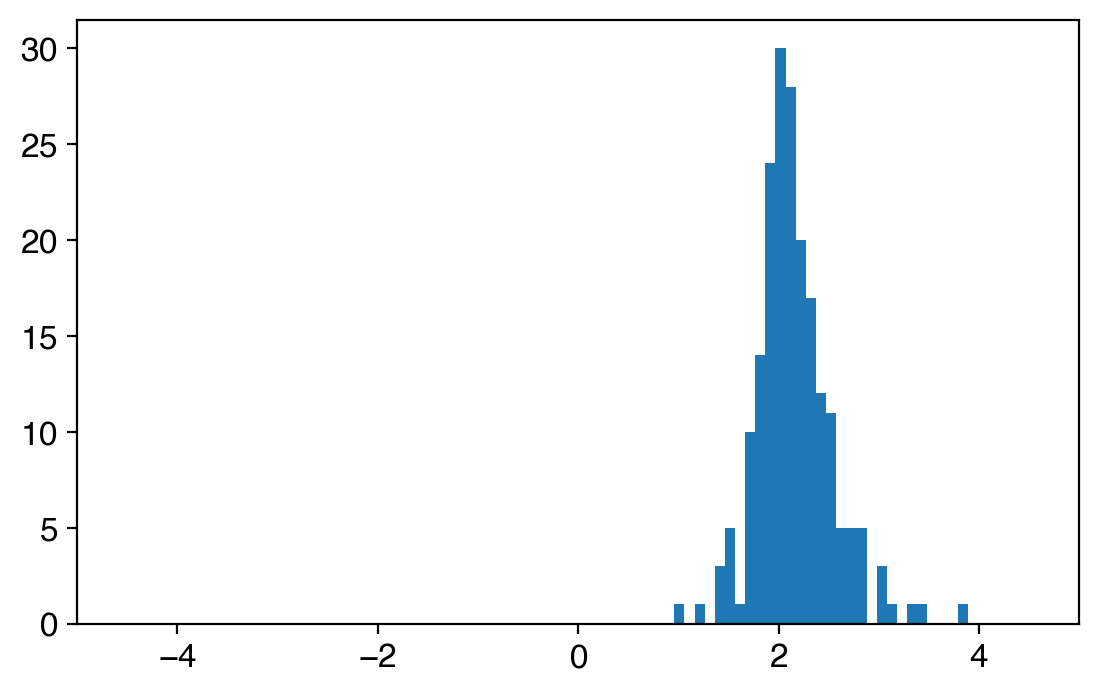

In [13]:
%%time
# get_hist(ddf, "logabsetaphi", sel="pass_baseline_iso and DV_rhoCorr>2.5", bins=np.linspace(-5,5,100)).plot()
# get_hist(ddf, "logabsetaphi", bins=np.linspace(-5,5,100)).plot()
get_hist(ddf, "logabsetaphi", sel="pass_baseline_iso and dimuon_mass>5 and DV_rhoCorr>2.5", bins=np.linspace(-5,5,100)).plot()

In [14]:
1e-6*ddf.memory_usage().sum().compute()

2314.567044

In [15]:
bins = [np.linspace(-15,15,200),np.linspace(-15,15,200)]
counts = hist2d_dask(ddf.query("pass_baseline_iso"), x="DV_x", y="DV_y", bins=bins).compute()
h = Hist2D.from_bincounts(counts, bins, errors=counts**0.5)

(<matplotlib.image.AxesImage at 0x7f2f40330ee0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2f3952b8b0>)

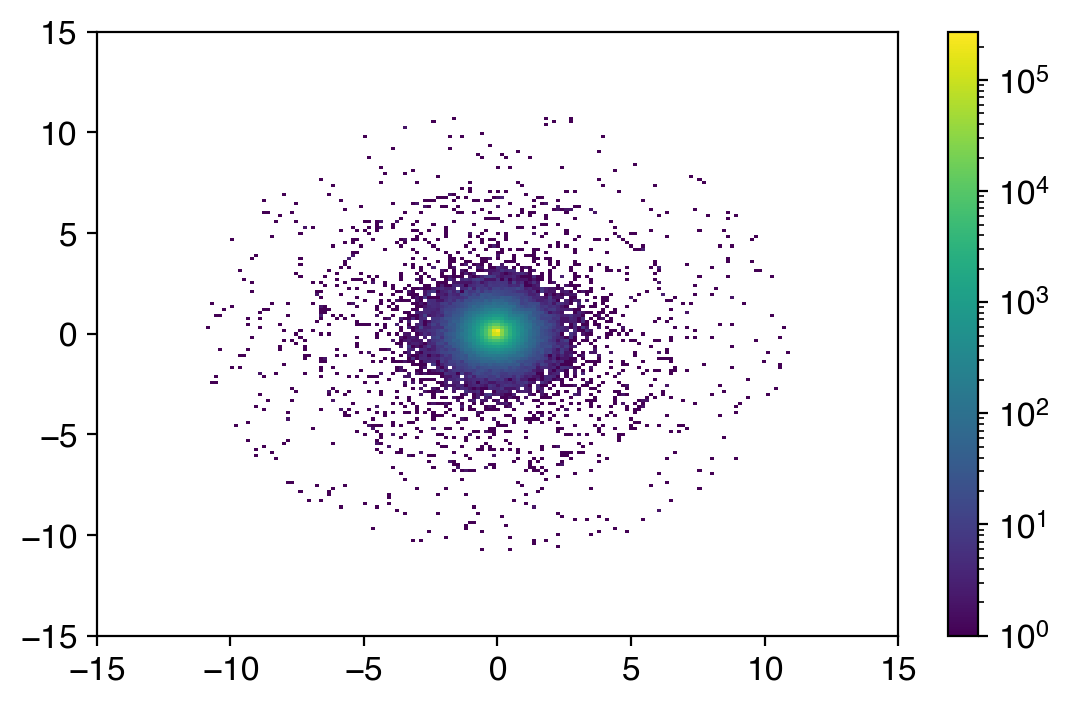

In [16]:
h.plot(logz=True)

In [37]:
df = ddf.query(
        "DV_rhoCorr>1.0 and pass_excesshits and logabsetaphi<1.5 and pass_baseline_iso and minabsdxy > 0.05"
    )
bins = [np.linspace(-15,15,200),np.linspace(-15,15,200)]
counts = hist2d_dask(df, x="DV_x", y="DV_y", bins=bins).compute()

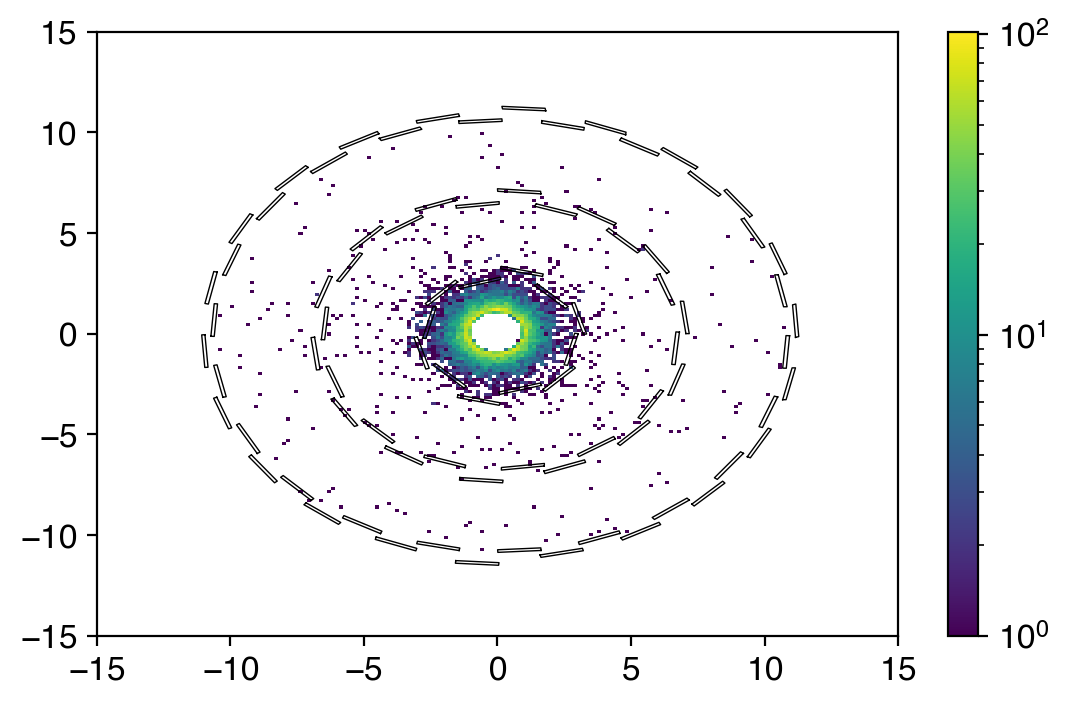

In [39]:
h = Hist2D.from_bincounts(counts, bins)
fig, ax = plt.subplots()
h.plot(ax=ax, logz=True)

utils.plot_overlay_bpix(ax=ax, lw=0.5,